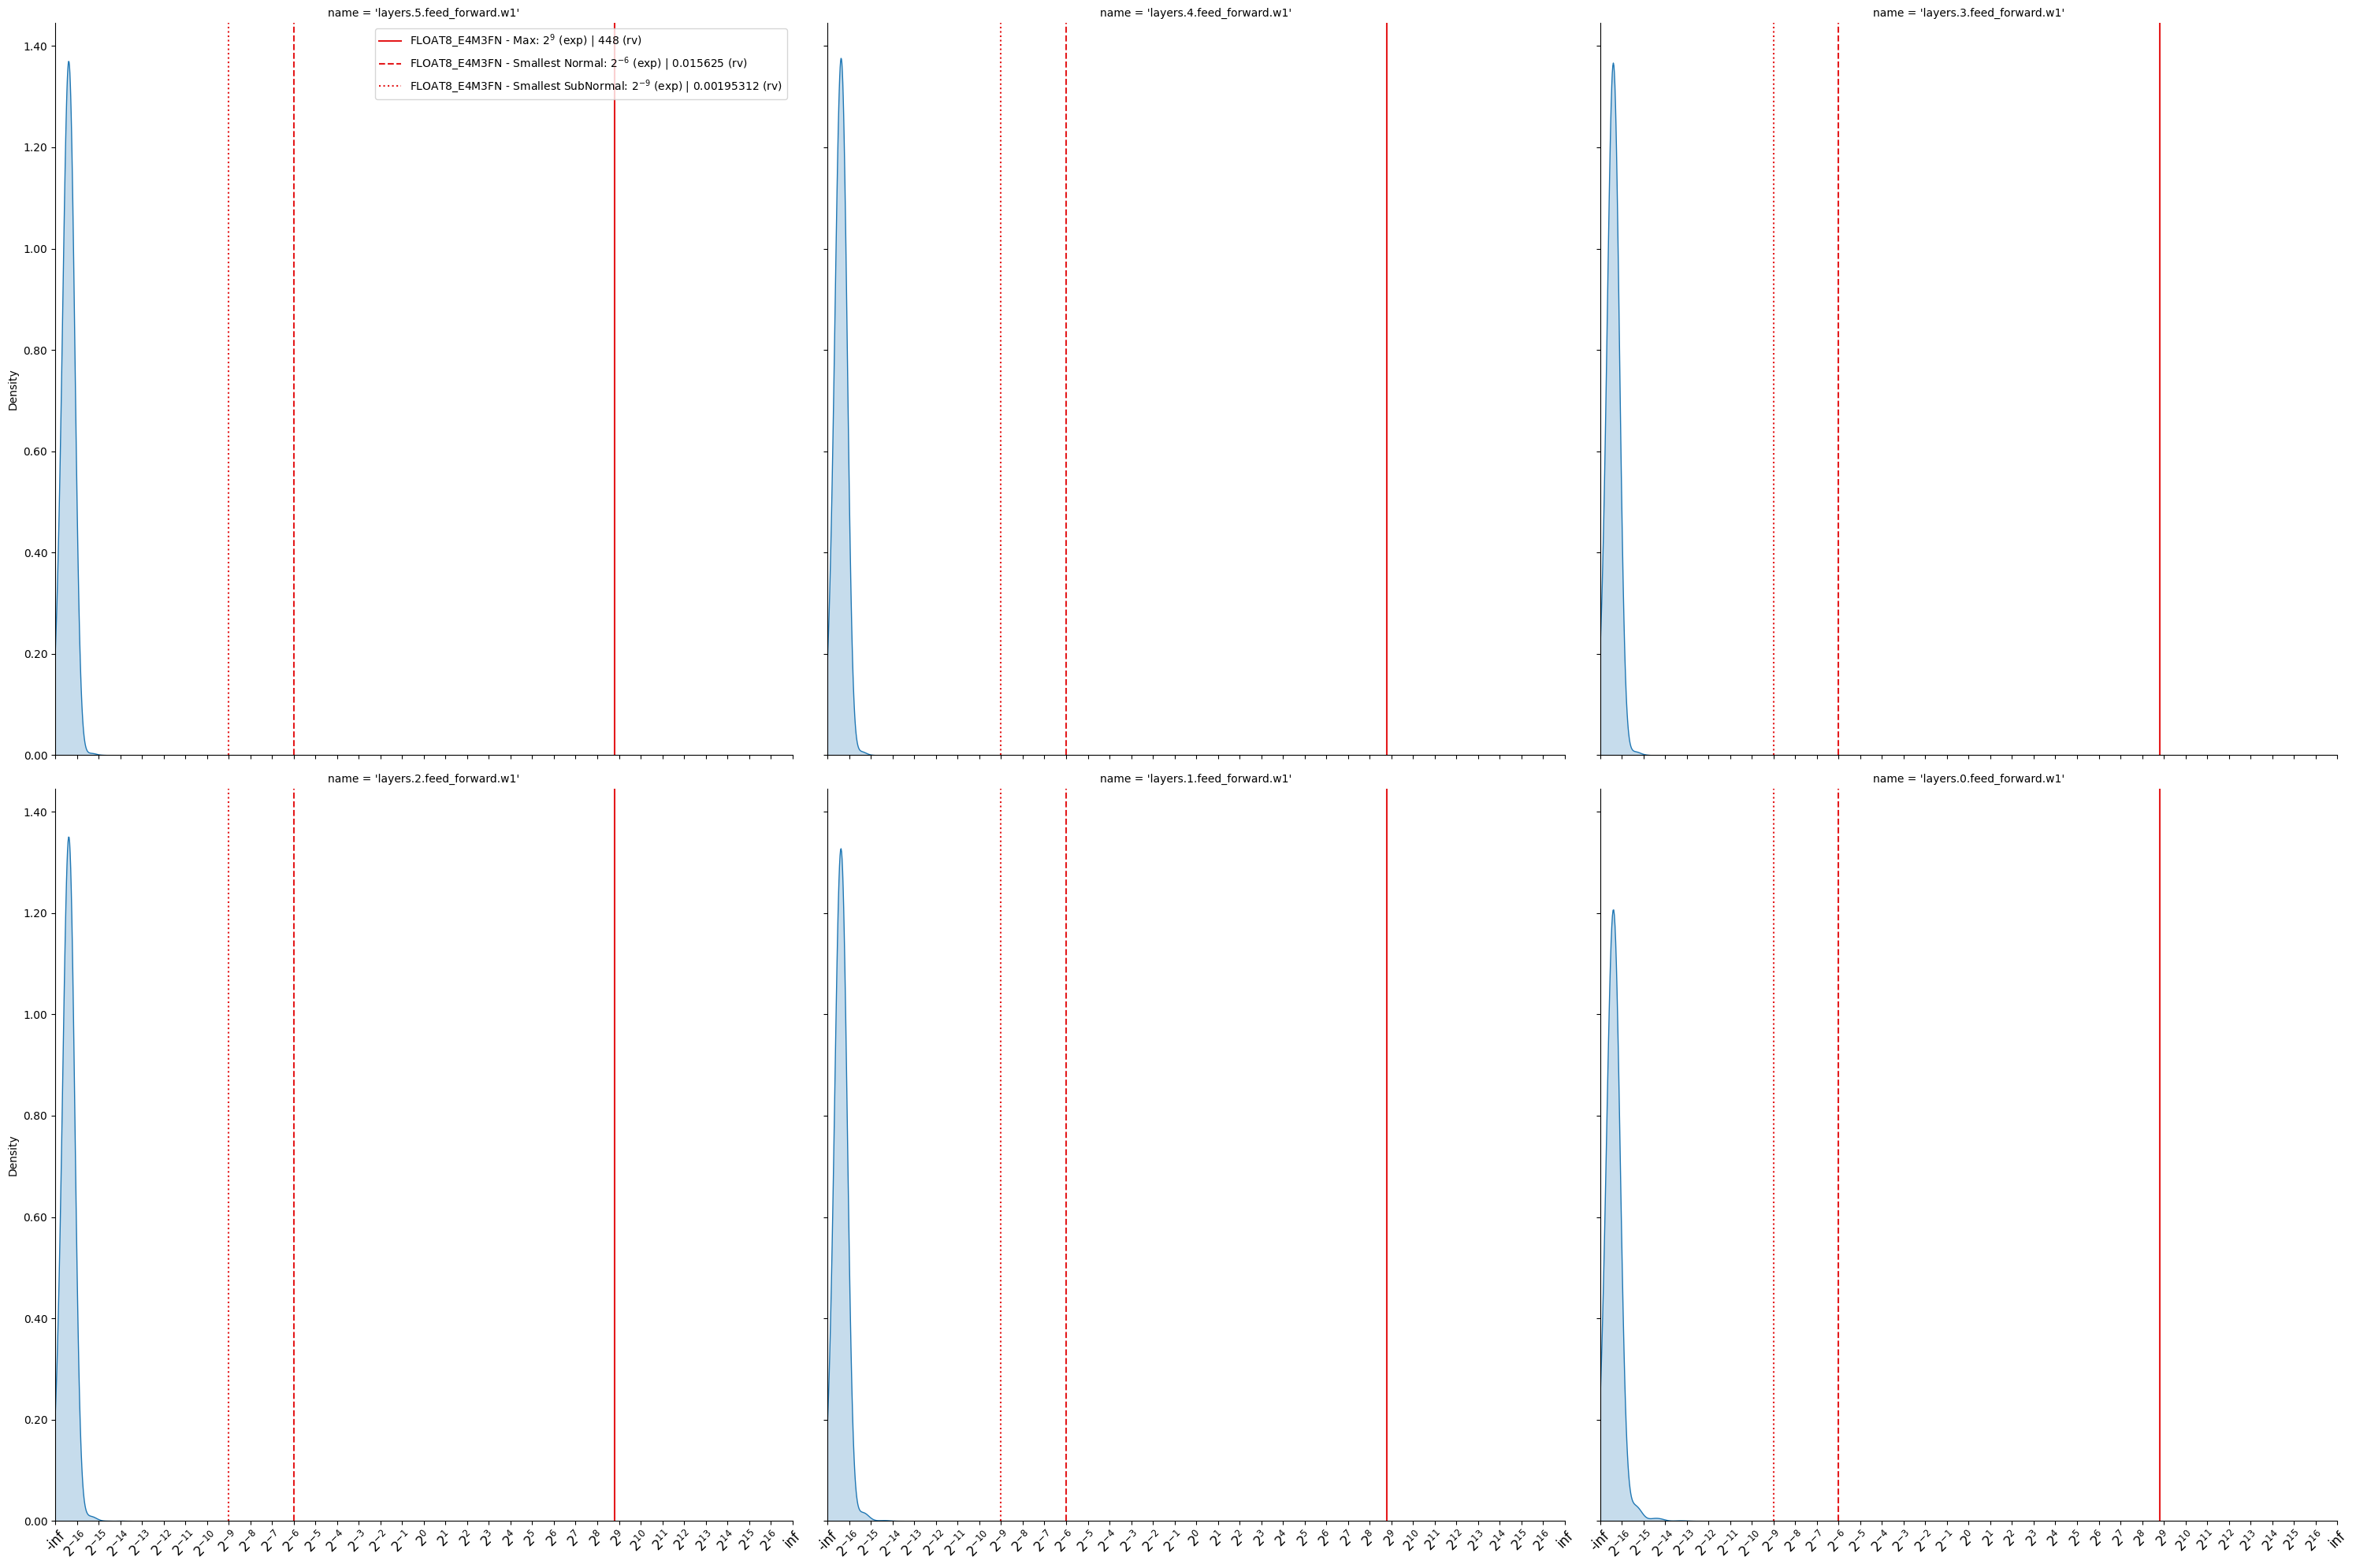

In [1]:
import os
import sys
import matplotlib.pyplot as plt
# add local lib to sys path for relative import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# import pandas as pd
from src import vis
from src.log.common import read_pickle, TensorType
import re
from ipywidgets import interact, widgets,fixed, AppLayout
import pandas as pd
df = read_pickle('../test-data/numerics_df_v3.pkl')

fig=vis.exp_hist(
    df,
    layer=re.compile('layers.[0-5].feed_forward.w1'),
    tt=TensorType.Gradient,
    step=0,
    kind='kde',
    col_wrap=3,
    dtype_info=(True, True, True),
    dtype_annotation= True,
)



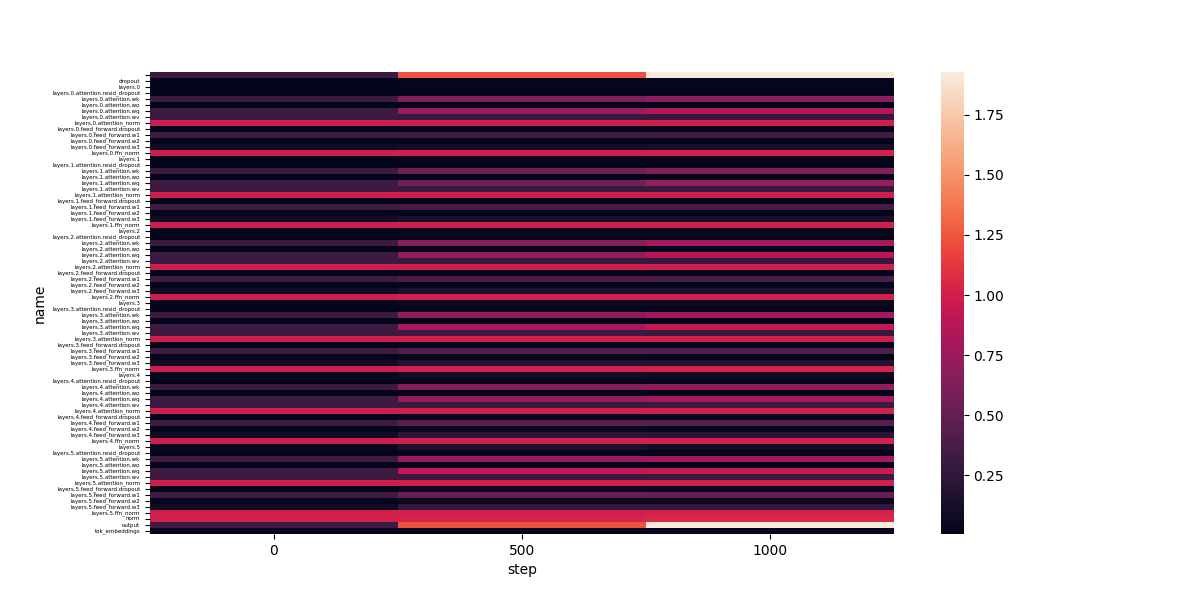

In [6]:
import matplotlib
import matplotlib.backend_bases
import itertools
import numpy as np
plt.switch_backend('ipympl')

axes_stack = []

glo_tt = TensorType.Activation

def sgh_interactive():
    fig = vis.scalar_global_heatmap(df=df, tt=glo_tt,scalar_metric='std', inc=500, yticklabels=True, figsize=(12,6))
    # axes_stack.append(fig.figure.axes.copy())
    return fig

fig = sgh_interactive()

def enter_axes(event):
    print('enter_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()



def onclick(event: matplotlib.backend_bases.MouseEvent):
    # where is the mouse w.r.t to x-tickets / y-ticks (this will form the query)
    if event.button == 1:
        
        print(event.xdata,event.ydata)
        # event.canvas.figure.axes[0].transData.transform()
        # for ax in event.canvas.figure.axes:
            # ax.cla()

        # check if item is in the mesh grid
        tf, ind =  event.canvas.figure.axes[0].collections[0].contains(event)
        if tf:
            # from the current fig get the x,y labels so that clicking can 
            x_vals = [int(l.get_text()) for l in  event.canvas.figure.axes[0].get_xticklabels()]
            y_vals = [l.get_text() for l in event.canvas.figure.axes[0].get_yticklabels()]
            prod_xy = list(itertools.product(y_vals,x_vals))

            # use the index of the object in the mesh grid to get the query params (l_name, Step)
            layer_name, step = prod_xy[ind['ind'].item()]

            # clear all axes from the figure
            event.canvas.figure.clear()
            # create new axes
            new_ax = event.canvas.figure.gca()
            # print(new_ax)
            # print(event.canvas.figure.axes)
            _df = df.query(f'@df.metadata.name == "{layer_name}" & @df.metadata.grad == "{glo_tt.name}"').pipe(lambda x: x[x.metadata.step == step])

            plotter = vis._ExpHistPlotter(
                kind='bar',
                sp_kws={},
                xtick_labelsize=6,
                xtick_rotation=45,
                dtype_annotation=True,
                logged_dtypes=_df.metadata.dtype.unique().tolist(),
                dtype_info=(True,True,True),
                legend_kws = dict(fontsize=10,loc='upper right')
            )
            
            
            plotter._plot_single(_df,new_ax)

            # new_ax.scatter(np.random.randint(0,100, (100,)), np.random.randint(0,100, (100,)))
            # event.canvas.figure.delaxes(event.canvas.figure.gca())
            
            # event.canvas.flush_events()
            # event.canvas.figure.add_axes(new_fig.axes[0])
            event.canvas.figure.suptitle(f'Layer: {layer_name}, Step: {step}, TT: {glo_tt}')
            # print(event.canvas.callbacks.__dict__)

            # event.canvas.mpl_disconnect(cid=cid)
            event.canvas.draw()

    elif event.button == 3:
        
        if len(axes_stack) > 0:
            for ax in event.canvas.figure.axes:
                event.canvas.figure.delaxes(ax)

            
            event.canvas.flush_events()
            # event.canvas.figure.add_axes(axes_stack[0])
            event.canvas.mpl_disconnect(cid=cid)
            print(event.canvas.events)
            # event.canvas.draw()
    

cid = fig.figure.canvas.mpl_connect('button_press_event', onclick)

# fig.figure.canvas.mpl_connect('figure_enter_event', enter_figure)
# fig.figure.canvas.mpl_connect('figure_leave_event', leave_figure)
# fig.figure.canvas.mpl_connect('axes_enter_event', enter_axes)
# fig.figure.canvas.mpl_connect('axes_leave_event', leave_axes)
# fig.figure.canvas.draw()

# means of tracking the navstack

plt.show(fig)

In [ ]:
# fig.canvas.figure.


In [2]:
# plt.switch_backend('module://matplotlib_inline.backend_inline')
plt.switch_backend('ipympl')

# out_box = widgets.Output(layout=widgets.Layout(width='100%', height='600px'))

def f(df,plot,step, layer, tt,**kwargs):
    tt = list(tt)
    layer= list(layer)
    # print(layer)
    if len(layer) != 0:
        # out_box.clear_output()
        # with out_box:
            # with plt.ioff():
        fig = vis.exp_hist(
            df,
            layer=layer if len(layer) > 1 else layer[0],
            tt=tt if len(tt) > 1 else tt[0],
            step=step,
            kind=plot,
            **kwargs
            )
        _ = fig.tight_layout()



def interact_exp_hist(df: pd.DataFrame, **kwargs):

    for fgn in plt.get_fignums():
        plt.close(fgn)
    
    ptype_layout = widgets.Layout()

    ptype = widgets.Dropdown(
        options=['line','bar','kde'], 
        value='bar',
        layout=ptype_layout)

    step_sel_layout = widgets.Layout(width='95%')
    step_sel = widgets.IntSlider(
                 min=df.metadata.step.min(),
                 max=df.metadata.step.max(),
                 step=1,
                 value=df.metadata.step.min(),
                 layout=step_sel_layout
                 )
    
    layer_sel_layout = widgets.Layout(
        width='50%', 
        border='solid 1px')

    layer_sel = widgets.TagsInput(
        allowed_tags=df.metadata.name.unique().tolist(), 
        value = (df.metadata.name.unique()[0],),
        layout=layer_sel_layout)

    tt_sel_layout = widgets.Layout()
    tt_sel = widgets.SelectMultiple(
        options=df.metadata.grad.unique().tolist(), 
        value=(df.metadata.grad.unique().tolist()[0],),
        layout=tt_sel_layout)
    



    hbox_layout = widgets.Layout(width='95%',flex_flow='row',display='flex',align_items='stretch')
    hbox = widgets.HBox(children=[ptype,tt_sel,layer_sel],
                        layout=hbox_layout)

    

    ui = widgets.VBox(children=[step_sel,hbox])
    
    
    dct = dict(
          df = fixed(df),
          plot = ptype,
         step = step_sel,    
         layer=layer_sel,
         tt=tt_sel)
    dct.update({k: fixed(v) for k,v in kwargs.items()})
    
    out = widgets.interactive_output(f, dct)
    display(ui,out)

         

interact_exp_hist(df,col_wrap=4, figsize = (10,5),dtype_info=(True, False, True),dtype_annotation= True)




Output()

In [ ]:
plt.g

In [ ]:
# Y-Axis, X-axis Formatting not consistent for kde plots
# Y-axis not consistent for hist

In [ ]:
from ipywidgets import AppLayout, FloatSlider, VBox, Checkbox, Layout, Button, Box, Label, SelectMultiple
import matplotlib.pyplot as plt
import numpy as np

plt.ioff()
plt.switch_backend('ipympl')

slider = FloatSlider(
    orientation='horizontal',
    description='Factor:',
    value=1.0,
    min=0.02,
    max=2.0
)

data = [f"data{i}" for i in range(50)]
checkboxes = [Checkbox(value=False, description=label) for label in data]
output = VBox(children=checkboxes)
# output.layout.max_width = '50%'
output.layout.margin = '50px 10% 0px 10%'
output.layout.overflow = 'scroll hidden'
output.layout.max_height = '200px'


slider.layout.margin = '0px 10% 0px 10%'
slider.layout.width = '40%'

fig = plt.figure()
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
plt.title('Plotting: y=sin({} * x)'.format(slider.value))

x = np.linspace(0, 20, 500)

lines = plt.plot(x, np.sin(slider.value * x))

def update_lines(change):
    plt.title('Plotting: y=sin({} * x)'.format(change.new))
    lines[0].set_data(x, np.sin(change.new * x))
    fig.canvas.draw()
    fig.canvas.flush_events()

slider.observe(update_lines, names='value')

item_layout = Layout(height='100px', min_height='100px', min_width='40px')
items = [Checkbox(description=str(i), button_style='warning') for i in range(40)]
box_layout = Layout(overflow='scroll hidden',
                    # border='3px solid black',
                    width='',
                    height='',
                    flex_flow='row',
                    display='flex')
carousel = Box(children=items, layout=box_layout)
footer = VBox([Label('Scroll horizontally:'), carousel])

AppLayout(
    # height='300px',
    center=fig.canvas,
    header=footer,
)

# Interactive Hist App

In [ ]:
import seaborn as sns


In [ ]:
import traitlets
import traitlets.utils
import traitlets.utils.bunch
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

print(plt.get_fignums())

if len(plt.get_fignums()) > 0:
    plt.close(plt.gcf())



plt.rcParams['toolbar'] = 'None'
plt.ioff()
plt.switch_backend('ipympl')
step_slider = widgets.IntSlider(
                 min=0,
                 max=1000,
                 step=1,
                 value=0, layout=widgets.Layout(width="100%"))
plot_selector = widgets.Dropdown(options=['line','bar','kde'], value='bar', layout=widgets.Layout(width="95%"))
tt_selector = widgets.SelectMultiple(options=['a','b','c'], value=['a'], layout=widgets.Layout(width="95%"))
vbox_layout = widgets.Layout(min_height= '400px', min_width='200px')
layer_input = widgets.TagsInput(allowed_tags=['a','b','c'], value=['a'])
right_siderbar = widgets.VBox(
    layout=vbox_layout,
    children=[
    plot_selector,
    tt_selector,layer_input])

# figsize for sns.FacetGrid is the per plot figsize,
# it is then multiplied by n_rows (for height) & n_cols (for width)

fig=vis.exp_hist(
    df,
    layer=re.compile('layers.[0-5].feed_forward.w[1-3]'),
    tt=TensorType.Activation,
    step=1000,
    kind='kde',
    col_wrap=3,
    figsize=(3.9,3),
    dtype_info=(True, True, True),
    legend_kws = dict(fontsize=6,loc='upper right'),
    dtype_annotation= True,
)

print(fig.figure.get_figwidth())

fig.figure.canvas.header_visible = False
# fig.figure.canvas.toolbar = None
fig.figure.canvas.layout.min_height = '400px'
fig.figure.canvas.toolbar_visible = False

def update_fig(change: traitlets.utils.bunch.Bunch):

    fig.figure.canvas.draw()
    # fig.canvas.flush_events()

    ...

def onclick(event):
    if event.inaxes != None: # So clicking on the figure outside axes doesn't throw an error
        print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
            ('double' if event.dblclick else 'single', event.button,
            event.x, event.y, event.xdata, event.ydata))

cid = fig.figure.canvas.mpl_connect('button_press_event', onclick)

# fig.figure.canvas.



# step_slider.observe(update_fig,names='value')

step_slider.observe(lambda _: update_fig(1))


def enter_axes(event):
    print('enter_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()


# fig.figure.canvas.mpl_connect('figure_enter_event', enter_figure)
# fig.figure.canvas.mpl_connect('figure_leave_event', leave_figure)
# fig.figure.canvas.mpl_connect('axes_enter_event', enter_axes)
# fig.figure.canvas.mpl_connect('axes_leave_event', leave_axes)
print(fig.figure.get_constrained_layout())


box_layout = widgets.Layout(display='flex',
                    flex_flow='row',
                    overflow='scroll',
                    align_items='stretch',
                    border = 'solid 2px',
                    width='100%')
box_auto = widgets.VBox(children=[fig.figure.canvas], layout=box_layout)

# ...
# right_sidebar, left_sidebar, header, footer, Center
al = widgets.AppLayout(
    header=step_slider,
    center= box_auto,
    pane_widths = [0,9,1],
    pane_heights = [0,10,10],
    right_sidebar = None,
    left_sidebar= right_siderbar,
    # footer=layer_input,
    grid_gap= "10px",
    justify_items='center',
    align_items='center',
)

fig.figure.canvas.toolbar_position = 'bottom'
fig.figure.canvas.resizable=False

# make canvas width equal that of the bounding box...



# print(fig.figure.canvas.get_width_height())
# fig.figure.set_figwidth(al.center.get_width_height()[0]/fig.figure.dpi)
# fig.figure.set_figheight(al.center.get_width_height()[1]/fig.figure.dpi)
fig.figure.canvas.draw()

display(al)

In [ ]:
import traitlets
import traitlets.utils
import traitlets.utils.bunch
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

print(plt.get_fignums())

if len(plt.get_fignums()) > 0:
    plt.close(plt.gcf())



plt.rcParams['toolbar'] = 'None'
plt.ioff()
plt.switch_backend('ipympl')
step_slider = widgets.IntSlider(
                 min=0,
                 max=1000,
                 step=1,
                 value=0, layout=widgets.Layout(width="100%"))
plot_selector = widgets.Dropdown(options=['line','bar','kde'], value='bar', layout=widgets.Layout(width="95%"))
tt_selector = widgets.SelectMultiple(options=['a','b','c'], value=['a'], layout=widgets.Layout(width="95%"))
vbox_layout = widgets.Layout(min_height= '400px', min_width='200px')
layer_input = widgets.TagsInput(allowed_tags=['a','b','c'], value=['a'])
right_siderbar = widgets.VBox(
    layout=vbox_layout,
    children=[
    plot_selector,
    tt_selector,layer_input])

# figsize for sns.FacetGrid is the per plot figsize,
# it is then multiplied by n_rows (for height) & n_cols (for width)

fig=vis.exp_hist(
    df,
    layer=re.compile('layers.[0-5].feed_forward.w[1-3]'),
    tt=TensorType.Activation,
    step=1000,
    kind='kde',
    col_wrap=3,
    figsize=(3.9,3),
    dtype_info=(True, True, True),
    legend_kws = dict(fontsize=6,loc='upper right'),
    dtype_annotation= True,
)

print(fig.figure.get_figwidth())

fig.figure.canvas.header_visible = False
# fig.figure.canvas.toolbar = None
fig.figure.canvas.layout.min_height = '400px'
fig.figure.canvas.toolbar_visible = False

def update_fig(change: traitlets.utils.bunch.Bunch):

    fig.figure.canvas.draw()
    # fig.canvas.flush_events()

    ...

def onclick(event):
    if event.inaxes != None: # So clicking on the figure outside axes doesn't throw an error
        print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
            ('double' if event.dblclick else 'single', event.button,
            event.x, event.y, event.xdata, event.ydata))

cid = fig.figure.canvas.mpl_connect('button_press_event', onclick)

# fig.figure.canvas.



# step_slider.observe(update_fig,names='value')

step_slider.observe(lambda _: update_fig(1))


def enter_axes(event):
    print('enter_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()


# fig.figure.canvas.mpl_connect('figure_enter_event', enter_figure)
# fig.figure.canvas.mpl_connect('figure_leave_event', leave_figure)
# fig.figure.canvas.mpl_connect('axes_enter_event', enter_axes)
# fig.figure.canvas.mpl_connect('axes_leave_event', leave_axes)
print(fig.figure.get_constrained_layout())


box_layout = widgets.Layout(display='flex',
                    flex_flow='row',
                    overflow='scroll',
                    align_items='stretch',
                    border = 'solid 2px',
                    width='100%')
box_auto = widgets.VBox(children=[fig.figure.canvas], layout=box_layout)

# ...
# right_sidebar, left_sidebar, header, footer, Center
al = widgets.AppLayout(
    header=step_slider,
    center= box_auto,
    pane_widths = [0,9,1],
    pane_heights = [0,10,10],
    right_sidebar = None,
    left_sidebar= right_siderbar,
    # footer=layer_input,
    grid_gap= "10px",
    justify_items='center',
    align_items='center',
)

fig.figure.canvas.toolbar_position = 'bottom'
fig.figure.canvas.resizable=False

# make canvas width equal that of the bounding box...



# print(fig.figure.canvas.get_width_height())
# fig.figure.set_figwidth(al.center.get_width_height()[0]/fig.figure.dpi)
# fig.figure.set_figheight(al.center.get_width_height()[1]/fig.figure.dpi)
fig.figure.canvas.draw()

display(al)

In [ ]:
import traitlets
import traitlets.utils
import traitlets.utils.bunch
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

print(plt.get_fignums())

if len(plt.get_fignums()) > 0:
    for fg_n in plt.get_fignums():
        plt.close(fg_n)



plt.rcParams['toolbar'] = 'None'
plt.ioff()
plt.switch_backend('ipympl')
step_slider = widgets.IntSlider(
                 min=0,
                 max=1000,
                 step=1,
                 value=0, layout=widgets.Layout(width="100%"))
plot_selector = widgets.Dropdown(options=['line','bar','kde'], value='bar', layout=widgets.Layout(width="95%"))
tt_selector = widgets.SelectMultiple(options=['a','b','c'], value=['a'], layout=widgets.Layout(width="95%"))
vbox_layout = widgets.Layout(min_height= '400px', min_width='200px')
layer_input = widgets.TagsInput(allowed_tags=['a','b','c'], value=['a'])
right_siderbar = widgets.VBox(
    layout=vbox_layout,
    children=[
    plot_selector,
    tt_selector,layer_input])

# figsize for sns.FacetGrid is the per plot figsize,
# it is then multiplied by n_rows (for height) & n_cols (for width)

fig=vis.exp_hist(
    df,
    layer='layers.0.feed_forward.w1',
    tt=TensorType.Activation,
    step=1000,
    kind='kde',
    col_wrap=3,
    figsize=(12,3),
    xtick_labelsize=6,
    dtype_info=(True, True, True),
    legend_kws = dict(fontsize=6,loc='upper right'),
    dtype_annotation= True,
)

print(fig.figure.get_figwidth())

fig.figure.canvas.header_visible = False
# fig.figure.canvas.toolbar = None
fig.figure.canvas.layout.min_height = '400px'
fig.figure.canvas.toolbar_visible = False

def update_fig(change: traitlets.utils.bunch.Bunch):

    fig.figure.canvas.draw()
    # fig.canvas.flush_events()

    ...

def onclick(event):
    if event.inaxes != None: # So clicking on the figure outside axes doesn't throw an error
        print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
            ('double' if event.dblclick else 'single', event.button,
            event.x, event.y, event.xdata, event.ydata))

# cid = fig.figure.canvas.mpl_connect('button_press_event', onclick)

# fig.figure.canvas.



# step_slider.observe(update_fig,names='value')

step_slider.observe(lambda _: update_fig(1))


def enter_axes(event):
    print('enter_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()


# fig.figure.canvas.mpl_connect('figure_enter_event', enter_figure)
# fig.figure.canvas.mpl_connect('figure_leave_event', leave_figure)
# fig.figure.canvas.mpl_connect('axes_enter_event', enter_axes)
# fig.figure.canvas.mpl_connect('axes_leave_event', leave_axes)
# fig.figure.canvas.draw()
print(fig.figure.get_constrained_layout())


box_layout = widgets.Layout(display='flex',
                    flex_flow='row',
                    overflow='scroll',
                    align_items='stretch',
                    border = 'solid 2px',
                    width='100%')
box_auto = widgets.VBox(children=[fig.figure.canvas], layout=box_layout)

# ...
# right_sidebar, left_sidebar, header, footer, Center
al = widgets.AppLayout(
    header=step_slider,
    center= box_auto,
    pane_widths = [0,9,1],
    pane_heights = [0,10,10],
    right_sidebar = None,
    left_sidebar= right_siderbar,
    # footer=layer_input,
    grid_gap= "10px",
    justify_items='center',
    align_items='center',
)

fig.figure.canvas.toolbar_position = 'bottom'
fig.figure.canvas.resizable=False

# make canvas width equal that of the bounding box...



# print(fig.figure.canvas.get_width_height())
# fig.figure.set_figwidth(al.center.get_width_height()[0]/fig.figure.dpi)
# fig.figure.set_figheight(al.center.get_width_height()[1]/fig.figure.dpi)
fig.figure.canvas.draw()

display(al)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class DraggableRectangle:
    def __init__(self, rect):
        self.rect = rect
        self.press = None

    def connect(self):
        """Connect to all the events we need."""
        self.cidpress = self.rect.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.rect.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        """Check whether mouse is over us; if so, store some data."""
        if event.inaxes != self.rect.axes:
            return
        contains, attrd = self.rect.contains(event)
        if not contains:
            return
        print('event contains', self.rect.xy)
        self.press = self.rect.xy, (event.xdata, event.ydata)

    def on_motion(self, event):
        """Move the rectangle if the mouse is over us."""
        if self.press is None or event.inaxes != self.rect.axes:
            return
        (x0, y0), (xpress, ypress) = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        # print(f'x0={x0}, xpress={xpress}, event.xdata={event.xdata}, '
        #       f'dx={dx}, x0+dx={x0+dx}')
        self.rect.set_x(x0+dx)
        self.rect.set_y(y0+dy)

        self.rect.figure.canvas.draw()

    def on_release(self, event):
        """Clear button press information."""
        self.press = None
        self.rect.figure.canvas.draw()

    def disconnect(self):
        """Disconnect all callbacks."""
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)

fig, ax = plt.subplots()
rects = ax.bar(range(10), 20*np.random.rand(10))
drs = []
for rect in rects:
    dr = DraggableRectangle(rect)
    dr.connect()
    drs.append(dr)

plt.show()

In [ ]:
import numpy as np
class SnappingCursor:
    """
    A cross-hair cursor that snaps to the data point of a line, which is
    closest to the *x* position of the cursor.

    For simplicity, this assumes that *x* values of the data are sorted.
    """
    def __init__(self, ax, line):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        self.x, self.y = line.get_data()
        self._last_index = None
        # text location in axes coords
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            self._last_index = None
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            index = min(np.searchsorted(self.x, x), len(self.x) - 1)
            if index == self._last_index:
                return  # still on the same data point. Nothing to do.
            self._last_index = index
            x = self.x[index]
            y = self.y[index]
            # update the line positions
            self.horizontal_line.set_ydata([y])
            self.vertical_line.set_xdata([x])
            self.text.set_text(f'x={x:1.2f}, y={y:1.2f}')
            self.ax.figure.canvas.draw()


x = np.arange(0, 1, 0.01)
y = np.sin(2 * 2 * np.pi * x)

fig, ax = plt.subplots()
ax.set_title('Snapping cursor')
line, = ax.plot(x, y, 'o')
snap_cursor = SnappingCursor(ax, line)
fig.canvas.mpl_connect('motion_notify_event', snap_cursor.on_mouse_move)
plt.show()

In [ ]:
# precomputing all images
x = np.linspace(0,np.pi,200)
y = np.linspace(0,10,200)
X,Y = np.meshgrid(x,y)
parameter = np.linspace(-5,5)
example_image_stack = np.sin(X)[None,:,:]+np.exp(np.cos(Y[None,:,:]*parameter[:,None,None]))


with plt.ioff():
    fig = plt.figure()
im = plt.imshow(example_image_stack[0])

def update(change):
    im.set_data(example_image_stack[change['new']])
    fig.canvas.draw_idle()
    
    
slider = widgets.IntSlider(value=0, min=0, max=len(parameter)-1)
slider.observe(update, names='value')
widgets.VBox([slider, fig.canvas])
